# 確率勾配法によるパーセプトロンとロジスティック回帰の実装

2次元データの2クラス分類問題を解くパーセプトロンとロジスティック回帰を実装する．
ロジスティック回帰は通常はバッチ処理で行うが，ここではサンプルを1つづつ用いる確率勾配法を実装する．

# 準備

In [1]:
# load modules

import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
%matplotlib inline
# plt.gray();
plt.set_cmap(plt.cm.Paired);

import sklearn
from sklearn.datasets import make_blobs

from ipywidgets import interact, interactive, fixed, RadioButtons
import ipywidgets as widgets
from IPython.display import display

<Figure size 432x288 with 0 Axes>

In [2]:
# check versions

print("sklearn version :", sklearn.__version__, " >= 0.18.0")
print("numpy version :", np.__version__, " >= 0.12.0")
print("matplotlib version:", matplotlib.__version__, ">= 2.0.0")

sklearn version : 0.22.1  >= 0.18.0
numpy version : 1.18.1  >= 0.12.0
matplotlib version: 3.1.3 >= 2.0.0


# データセットの準備

sklearnのmake_blobで2次元データを準備する．
返り値は，データXとラベルyである．ただし2クラスの場合，ラベルyは0,1で返ってくるため，-1と+1に変更しておく．

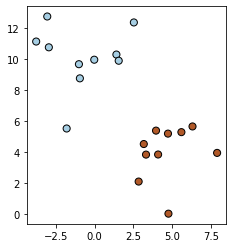

In [3]:
X, y = make_blobs(n_samples=20, # 20個生成
                  n_features=2, # 2次元
                  centers=2,    # クラスタ中心2個
                  cluster_std = 2 # クラスタの大きさ（標準偏差）
                 )
y = 2*y - 1 # 0,1 -> -1,+1

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, edgecolors='k');
plt.gca().set_aspect('equal');

識別境界を直線で描くヘルパー関数の準備．

In [4]:
# 境界線を引く関数の定義

def plotBoundary(X, w, mesh=True, boundary=True, n_neighbors=1):

    # plot range
    x_min = min(X[:,0])
    x_max = max(X[:,0])
    y_min = min(X[:,1])
    y_max = max(X[:,1])

    # visualizing decision function
    XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j] # make a grid
    Z = np.c_[XX.ravel(), YY.ravel(), np.ones(XX.size)] @ w
    
    Z = Z.reshape(XX.shape) # just reshape
    Z = np.sign(Z) # -1 or +1

    if mesh:
        plt.pcolormesh(XX, YY, Z, zorder=-10) # paint in 2 colors, if Z > 0 or not

    if boundary:
        if Z.min() < 0.5 < Z.max():
            plt.contour(XX, YY, Z, alpha=0.5,
                        colors='k', linestyles='-', levels=[0])

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

# パーセプトロンの実装

以下では，サンプルを先頭から順番に一つずつ用いて，パーセプトロンの更新則を適用する．
サンプルは青と茶色のクラスに分かれている．識別境界を引いた後に，同じ色の領域に入っていれば正答，違う色の領域に入ってしまっていれば誤答である．誤答の場合にのみパーセプトロンの更新則を適用する．

In [5]:
w = np.random.rand(3) - 0.5 # 次元＋1：同次座標

In [6]:
val_start = 0 # スライドバーの最小値
val_end   = len(y)-1 # スライドバーの最大値
val_step  = 1 # スライドバーはこの値ずつ増える
val_default = 0 # スライドバーの初期値


@interact(sample=(val_start, val_end, val_step)) # この行が関数の直前に必要
def g(sample=val_default): # この関数を毎回呼び出す    
    
    global w
    
    if sample > len(y)-1:
        return

    plt.scatter(X[:, 0], X[:, 1], marker='o', s=50, c=y, edgecolors='k')
    plt.scatter(X[sample, 0], X[sample, 1], marker='o', s=90, facecolors='none',  edgecolors='k')
   
    plotBoundary(X, w)
    
    xi = np.hstack((X[sample], 1)) 
    yi = y[sample]

    plt.title("y w x = {0:.2f}".format((xi @ w) * yi))
    
    plt.gca().set_aspect('equal');
    plt.show()

    # パーセプトロンの更新則
    if (xi @ w) * yi < 0:
        alpha = 0.001
        w = w + alpha * yi * xi

    

interactive(children=(IntSlider(value=0, description='sample', max=19), Output()), _dom_classes=('widget-inter…

# Task

- 上記のパーセプトロンの更新則の部分を修正して，ロジスティック回帰の更新式を実装せよ．
- パーセプトロンとロジスティック回帰の収束の違いを議論せよ．

なお学習率$\alpha$は0.01から0.001程度にすると境界線の移動の様子がわかりやすい．

# ロジスティック回帰の実装

In [7]:
val_start = 0 # スライドバーの最小値
val_end   = len(y)-1 # スライドバーの最大値
val_step  = 1 # スライドバーはこの値ずつ増える
val_default = 0 # スライドバーの初期値


w = np.random.rand(3) - 0.5 # 次元＋1：同次座標

def sig(x):
    return 1 / (1 + np.exp(x))

X = np.hstack((X, np.ones((X.shape[0], 1)))) # 同次座標


@interact(sample=(val_start, val_end, val_step)) # この行が関数の直前に必要
def g(sample=val_default): # この関数を毎回呼び出す    
    
    global w
    
    if sample > len(y)-1:
        return

    plt.scatter(X[:, 0], X[:, 1], marker='o', s=50, c=y, edgecolors='k')
    plt.scatter(X[sample, 0], X[sample, 1], marker='o', s=90, facecolors='none',  edgecolors='k')
   
    plotBoundary(X, w)
    
    xi = X[sample]
    yi = y[sample]

#     plt.title("y w x = {0:.2f}".format((xi @ w) * yi))
    
    plt.gca().set_aspect('equal');
    plt.show()

    # ロジスティック回帰の更新則
    alpha = 0.001
    
    a = (X @ w) * y
    w += alpha * (X * y[:, np.newaxis] * sig(a)[:, np.newaxis]).sum(axis=0)
        

    

interactive(children=(IntSlider(value=0, description='sample', max=19), Output()), _dom_classes=('widget-inter…